<a href="https://colab.research.google.com/github/2-double-G/LSTM/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def preprocess(filename):
  '''Предварительная обработка данных'''
  drive.mount('/content/drive')  # подключаем google диск с файлами
  path = '/content/drive/My Drive/data'
  
  names = ['P1', 'P2', 'T11', 'T1', 'T21', 'Tnv']
  
  # читаем все данные в словарь вида: { имя_переменной: пандас_датасет }
  ds = dict() 
  for name in names:
      ds[name] = pd.read_csv(f'{path}/data-{name}.csv', sep=',',
                             header=0, names=['time', name],
                             parse_dates=['time']).set_index('time')

  # объединяем датасеты
  raw_data = pd.concat(ds.values(), axis=1)

  # добавляем Tp
  raw_data['Tp'] = (raw_data['Tnv'] +
                    (44 * (raw_data['T11'] + raw_data['T21']) - 2062) / 113)

  # заполняем отсутствующие значения (средним между ближайшими значениями)
  raw_data = 0.5 * (raw_data.fillna(method='ffill').fillna(method='bfill') +
                    raw_data.fillna(method='bfill').fillna(method='ffill'))

  # сохраняем на google диск
  raw_data.to_csv(f'{path}/{filename}', header=True)
  print(f'{filename} создан и сохранен!')

In [ ]:
preprocess('preprocessed.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
preprocessed.csv создан и сохранен!


In [ ]:
def read_data(filename):
  '''Чтение данных'''
  drive.mount('/content/drive')  # подключаем google диск с файлами
  return pd.read_csv(filename, sep=',', header=0,  parse_dates=['time']).set_index('time')

In [ ]:
class BasicModel:
  @staticmethod
  def prepare_X(raw_X, look_back):
    '''Преобразование данных для использования с LSTM.
    Для задачи предсказания по look_back предшествующих шагов.
    
    (timestamp, feature) -> (sample, sample timestamp, feature)
    '''
    data_size, num_features = raw_X.shape
    num_samples = data_size - look_back + 1  # кол-во полученных сэмплов
    X = np.empty((
        num_samples,
        look_back,
        num_features
    ))
    for i in range(num_samples):
      X[i] = raw_X[i:(i+look_back)]
    return X


  @staticmethod
  def prepare_y(raw_y, look_forward):
    '''Преобразование данных для использование с LSTM.
    Для задачи предсказания на look_forward шагов.

    (timestamp, 1) -> (sample, sample timestamp, 1)
    '''
    data_size = raw_y.shape[0]
    num_samples = data_size - look_forward + 1
    y = np.empty((
        num_samples,
        look_forward
    ))
    for i in range(num_samples):
      y[i] = raw_y[i:(i+look_forward), 0]
    return y


  @staticmethod
  def prepare_data(raw_X, raw_y, look_back, look_forward):
    assert raw_y.shape[0] == raw_X.shape[0]
    X = BasicModel.prepare_X(raw_X, look_back)
    y = BasicModel.prepare_y(raw_y, look_forward)
    # отбрасываем look_forward последних сэмплов X и look_back первых сэмплов y
    return X[:-look_forward], y[look_back:]


  def __init__(self,
               look_back,
               look_forward,
               num_neurons_1,  # число нейронов в LSTM слое
               activation_3,  # активационная функция в выходном слое
               loss,
               optimizer,
               num_epochs,
               batch_size):
    self.look_back = look_back
    self.look_forward = look_forward
    self.num_neurons_1 = num_neurons_1
    self.activation_3 = activation_3
    self.loss = loss
    self.optimizer = optimizer
    self.num_epochs = num_epochs
    self.batch_size = batch_size

    self.scaler_X = None
    self.scaler_y = None
    self.model = None


  def fit(self, raw_X, raw_y):
    # инициализация скейлеров для нормализация данных:
    self.scaler_X = MinMaxScaler(feature_range=(0, 1)) 
    self.scaler_y = MinMaxScaler(feature_range=(0, 1))

    # преобразование данных в формат для LSTM:
    X, y = BasicModel.prepare_data(
        self.scaler_X.fit_transform(raw_X),
        self.scaler_y.fit_transform(raw_y),
        self.look_back,
        self.look_forward
    )

    # делим данные на train и test:
    # - по train будем учиться
    # - по test будем следить за переобучением и качеством обучения
    num_features = X.shape[2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

    self.model = Sequential()
    
    self.model.add(LSTM(
        self.num_neurons_1,
        input_shape=(self.look_back, num_features))
    )

    # с помощью Dense слоя собираем выходы с LSTM слоя
    # в выходной вектор нужной размерности (длины look_forward)
    self.model.add(Dense(
        self.look_forward,
        activation=self.activation_3)
    )
    
    self.model.compile(
        loss=self.loss,
        optimizer=self.optimizer
    )

    history = self.model.fit(X_train, y_train, verbose=1,
                             epochs=self.num_epochs,
                             batch_size=self.batch_size,
                             validation_data=(X_test, y_test), shuffle=True)
    
    return history


  def predict(self, X):
    assert X.shape[0] >= self.look_back
    X = self.scaler_X.transform(X)  # нормализуем, используя сохраненный скейлер
    X = BasicModel.prepare_X(X, self.look_back)  # делаем сэмплы для LSTM
    y_pred = self.model.predict(X)  # предсказываем

    # y_pred = набор нормализованных строк длины look_forward
    # - транспонируем каждую строку в столбец (reshape)
    # - выполняем scaler_y.inverse_transform
    # - транспонируем обратно в строку (flatten)

    def rescale(row):
      '''Обратное преобразование нормализованного выходного вектора'''
      return self.scaler_y.inverse_transform(row.reshape(-1, 1)).flatten()
    
    return np.apply_along_axis(rescale, 1, y_pred)

  def error(self, X, y_true):
    '''mean_squared_error от предсказания на X и реальных значений y_true'''
    assert X.shape[0] == y_true.shape[0]

    # по X мы не можем предсказать первые look_back значений,
    # поэтому их отбрасываем, а остальные приводим к виду, в котором получим предсказания
    y_true = y_true[self.look_back:]
    y_true = BasicModel.prepare_y(y_true, self.look_forward)

    # в y_true нет последних look_forward предсказаний из y_pred,
    # поэтому их отбрасываем  
    y_pred = self.predict(X)[:-self.look_forward]
    
    return mean_squared_error(y_true, y_pred, multioutput='uniform_average')

In [ ]:
def show_history(history):
  '''Построение графиков по истории обучения keras модели'''
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def main():
  raw_data = read_data('/content/drive/My Drive/data/preprocessed.csv')

  # объединяем по часам и усредняем:
  hours = raw_data.groupby(by=lambda dt: dt.floor('h')).mean()
  
  # выбираем признаки, которые будем использовать:
  X, y = np.array(hours[['Tnv']]), np.array(hours[['Tnv']])
  
  # параметры предсказания: на 12 часов вперед по 48 предыдущим часам
  look_back, look_forward = 48, 13

  # часть данных оставим для валидации (оценки результатов метода)
  X_val, X_train, y_val, y_train = train_test_split(X, y, test_size=0.90, shuffle=False)
  model = BasicModel(look_back=look_back,
                     look_forward=look_forward,
                     num_neurons_1=64,
                     # num_neurons_2=32,
                     # activation_2='relu',
                     activation_3='tanh',
                     loss='mean_squared_error',
                     optimizer='adam',
                     num_epochs=35,
                     batch_size=10)
  
  history = model.fit(X_train, y_train)
  show_history(history)

  print(f'Ошибка на валидации: {model.error(X_val, y_val)}')

  # Для демонстрации визуализируем 5 предсказаний сэмплов из валидационных данных:  
  for _ in range(5):
   i = np.random.randint(look_back, y_val.shape[0] - look_forward)
   y_true = y_val[i:(i+look_forward)].flatten()
   y_pred = model.predict(X_val[(i-look_back):i, :])[0]
   hist = y_val[(i-look_back):i].flatten()
   plt.figure(figsize=(15, 6))
   plt.title("Ошибка на валидации {}\n Ошибка в данной выборке {}".format(model.error(X_val, y_val), mean_squared_error(y_true, y_pred, multioutput='uniform_average')), fontsize = 15)
   plt.ylabel('Tnv, °C',fontsize = 15)
   plt.xlabel('t, ч',fontsize = 15)
   plt.plot(np.concatenate((hist, y_pred)), "r", label = "Прогноз")
   plt.plot(np.concatenate((hist, y_true)), label = "Актуальные значения")
   plt.legend(loc='best',fontsize = 15)
   plt.xlim(right = 60)
   plt.xlim(left = 0)
   l=np.concatenate((hist, y_pred))
   plt.axvspan(len(hist), len(l), alpha=0.5, color='lightgrey')
   plt.grid(True)
   plt.show()
  

  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train on 1132 samples, validate on 126 samples
Epoch 1/35
1132/1132 [==============================] - 3s 2ms/step - loss: 0.0424 - val_loss: 0.0175
Epoch 2/35
1132/1132 [==============================] - 2s 2ms/step - loss: 0.0110 - val_loss: 0.0183
Epoch 3/35
1132/1132 [==============================] - 2s 2ms/step - loss: 0.0104 - val_loss: 0.0146
Epoch 4/35
1132/1132 [==============================] - 2s 2ms/step - loss: 0.0101 - val_loss: 0.0146
Epoch 5/35
1132/1132 [==============================] - 2s 2ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 6/35
1132/1132 [==============================] - 2s 2ms/step - loss: 0.0092 - val_loss: 0.0113
Epoch 7/35
1132/1132 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 8/35
1132/1132 [==============================] - 3s 2ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 9/

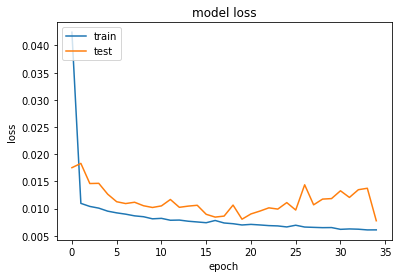

Ошибка на валидации: 0.988661022491592


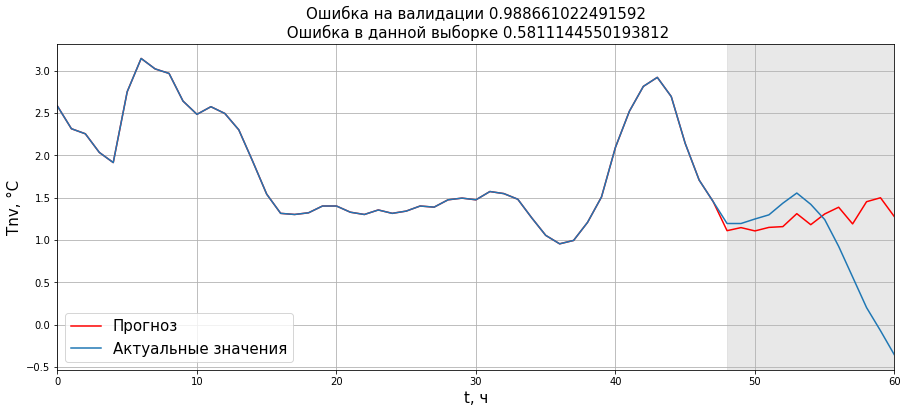

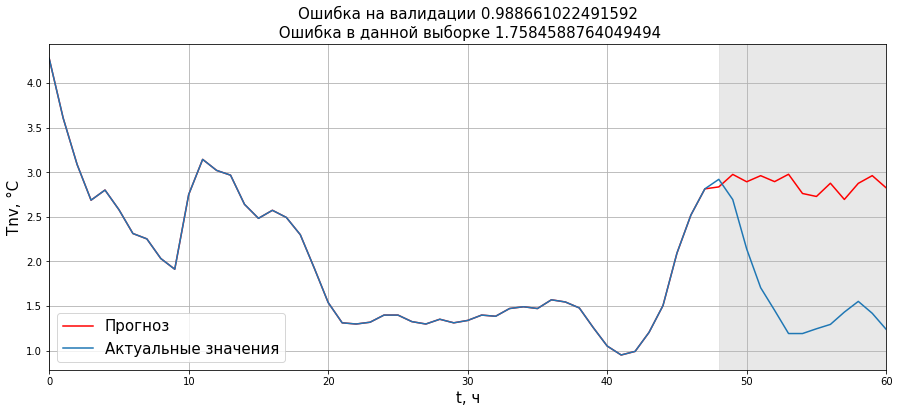

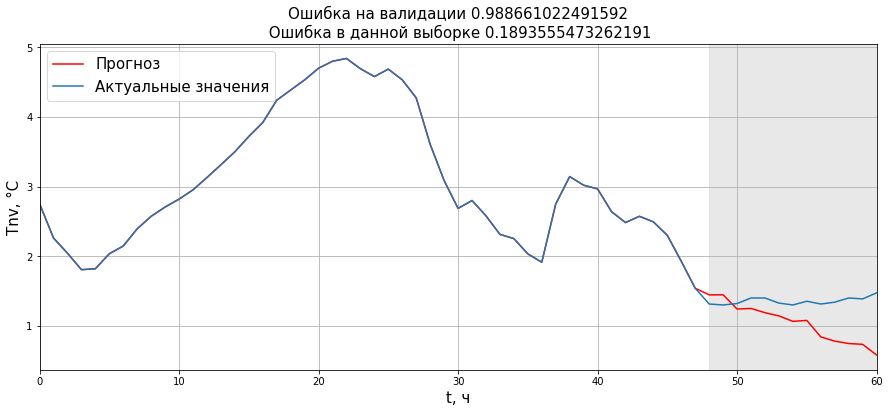

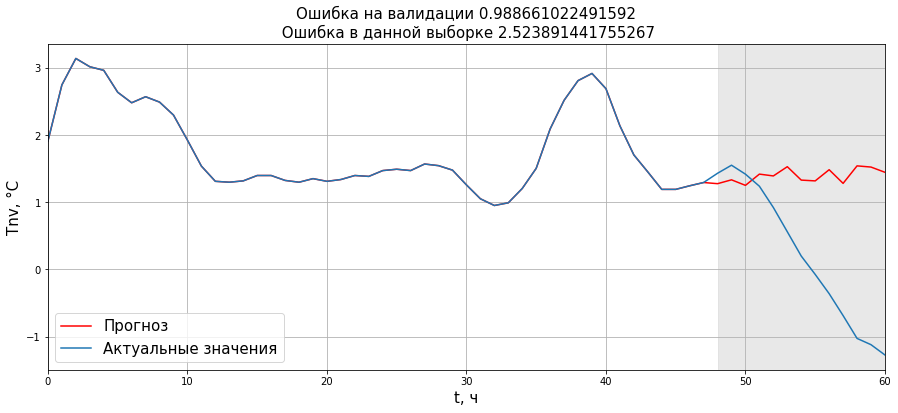

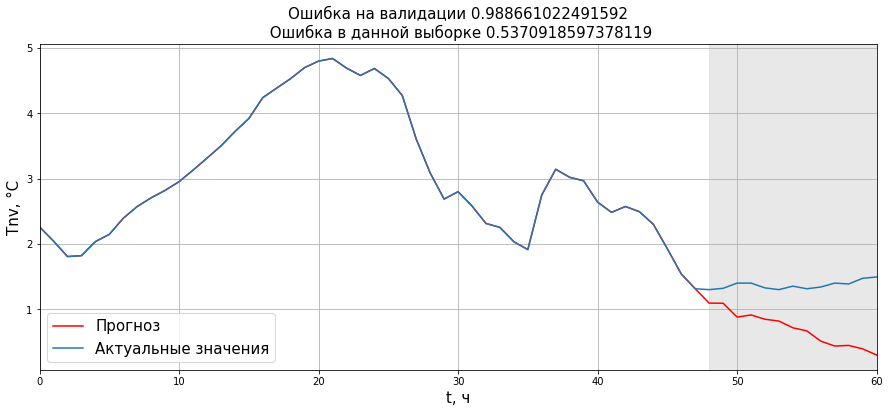

CPU times: user 2min 22s, sys: 6.67 s, total: 2min 28s
Wall time: 1min 28s


In [ ]:
%%time
main()
